# **Fianl Project**
#### Lejia Xu SID: 918195599 

## **Part 1: EDA**
### **Part 1.1 Data Description**

In [64]:
import pandas as pd
import numpy as np

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, classification_report
)

import matplotlib.pyplot as plt
from scipy.stats import chi2

In [35]:
#Load dataset
df = pd.read_csv("wine.csv")
df.head()
df.describe().T

df['high_quality'] = (df['quality'] == 7).astype(int)
df['high_quality'].value_counts()

print(df.dtypes)

fixed.acidity           float64
volatile.acidity        float64
citric.acid             float64
residual.sugar          float64
chlorides               float64
free.sulfur.dioxide     float64
total.sulfur.dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
red                       int64
high_quality              int32
dtype: object


In [36]:
# check if missing value
print(df.isnull().sum())

fixed.acidity           0
volatile.acidity        0
citric.acid             0
residual.sugar          0
chlorides               0
free.sulfur.dioxide     0
total.sulfur.dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
red                     0
high_quality            0
dtype: int64


In [37]:
df.groupby("high_quality").mean()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,red
high_quality,,,,,,,,,,,,,
0,7.4650,0.4123,0.2844,4.759375,0.067397,26.98625,97.5700,0.995778,3.251275,0.56330,10.162000,5.5,0.5
1,7.8255,0.3350,0.3570,3.788500,0.057535,24.83750,80.9375,0.994151,3.244000,0.62475,11.516383,7.0,0.5


**Quality mean analysis**  
High-quality wines (quality = 7) exhibit several distinct chemical characteristics compared to lower-quality wines (quality = 5–6). On average, they contain higher alcohol content and more sulphates, while showing lower volatile acidity, less residual sugar, and lower total sulfur dioxide. In addition, high-quality wines have slightly higher fixed and citric acidity, along with a lower density, consistent with their higher alcohol levels.

For variables with more skewed distributions, such as residual sugar and total sulfur dioxide, median values provide a more robust summary than means, since extreme cases may inflate the averages. Nevertheless, the overall pattern remains consistent: high-quality wines generally show lower sugar and sulfur levels than lower-quality wines.

These preliminary comparisons suggest that alcohol, volatile acidity, and sulphates are the strongest differentiating factors between high- and low-quality wines. Such variables are likely to emerge as important predictors in subsequent statistical testing and logistic regression models.

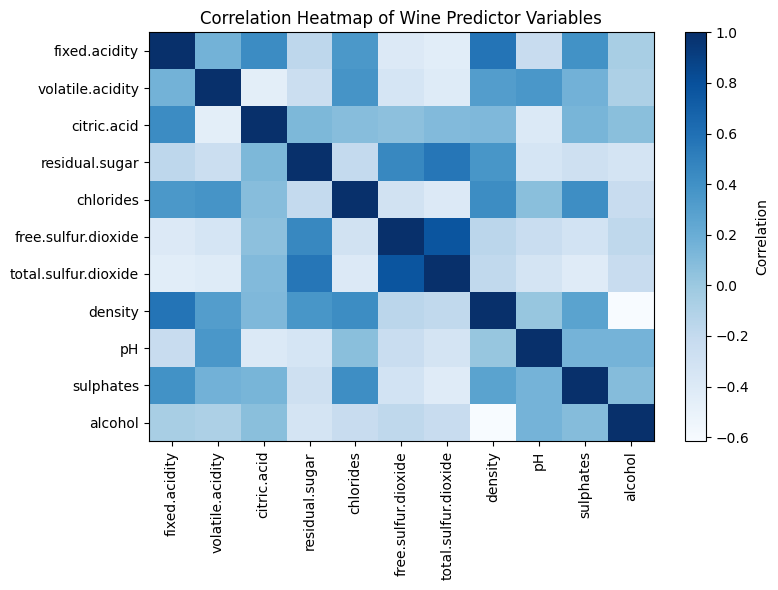

In [29]:
#Correlation heatmap
corr = df.drop(columns=['quality', 'red', 'high_quality']).corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="Blues", interpolation="none", aspect="auto")
plt.colorbar(label="Correlation")

plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)

plt.title("Correlation Heatmap of Wine Predictor Variables")
plt.tight_layout()
plt.show()


In [12]:
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

corr_pairs.columns = ["Var1", "Var2", "Correlation"]

ranked_corr = corr_pairs.sort_values(by="Correlation", key=lambda x: x.abs(), ascending=False)

print(ranked_corr.head(10))   
print(ranked_corr.tail(10))   

                    Var1                  Var2  Correlation
40   free.sulfur.dioxide  total.sulfur.dioxide     0.766499
51               density               alcohol    -0.615877
6          fixed.acidity               density     0.576150
29        residual.sugar  total.sulfur.dioxide     0.564244
10      volatile.acidity           citric.acid    -0.454036
28        residual.sugar   free.sulfur.dioxide     0.452882
5          fixed.acidity  total.sulfur.dioxide    -0.440379
1          fixed.acidity           citric.acid     0.428409
47  total.sulfur.dioxide             sulphates    -0.424254
36             chlorides               density     0.420976
                Var1                  Var2  Correlation
23       citric.acid               density     0.115274
22       citric.acid  total.sulfur.dioxide     0.101173
18  volatile.acidity               alcohol    -0.089344
54         sulphates               alcohol     0.087595
20       citric.acid             chlorides     0.079903
26  

**Correlation Analysis**  
- Strong correlations  
Free sulfur dioxide and Total sulfur dioxide are strongly positively correlated (r ≈ 0.77), which is expected since total sulfur dioxide includes the free component.  
Alcohol and Density are strongly negatively correlated (r ≈ –0.62), consistent with the fact that ethanol is less dense than water. Other moderate-to-strong correlations include Fixed acidity with Density (r ≈ 0.58) and Residual sugar with Total sulfur dioxide (r ≈ 0.56). These redundant relationships motivate the use of PCA to reduce dimensionality.

- Weak correlations  
Fixed acidity and Alcohol (r ≈ –0.06), Citric acid and Free sulfur dioxide (r ≈ 0.06), and Density and pH (r ≈ 0.02) are nearly uncorrelated. Such variables provide independent information, but correlation alone does not indicate whether they are useful for distinguishing red and white wines. To further quantify group differences, Cohen’s d will be calculated in the next section to evaluate the discriminative power of each variable.

- Conclusion  
The dataset contains both redundant information, suitable for PCA, and potentially discriminative dimensions that require evaluation by effect size. This motivates a two-step approach: use PCA to reduce redundancy, and then use Cohen’s d together with LDA for supervised discrimination.

In [13]:
red = df[df["red"] == 1]
white = df[df["red"] == 0]

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * x.std()**2 + (ny - 1) * y.std()**2) / dof)
    return (x.mean() - y.mean()) / pooled_std

continuous_vars = df.select_dtypes(include=["float64", "float32"]).columns

d_values = {}
for col in continuous_vars:
    d_values[col] = cohens_d(red[col], white[col])

d_df = pd.DataFrame.from_dict(d_values, orient="index", columns=["Cohen_d"])
d_df["abs_d"] = d_df["Cohen_d"].abs()
d_df = d_df.sort_values("abs_d", ascending=False)

print(d_df)

                       Cohen_d     abs_d
total.sulfur.dioxide -2.775281  2.775281
free.sulfur.dioxide  -1.499297  1.499297
volatile.acidity      1.498326  1.498326
chlorides             1.230457  1.230457
sulphates             1.183965  1.183965
fixed.acidity         1.158169  1.158169
residual.sugar       -1.074968  1.074968
density               1.023352  1.023352
pH                    0.896881  0.896881
citric.acid          -0.296875  0.296875
alcohol               0.055965  0.055965


In [39]:
high = df[df["high_quality"] == 1]
not_high = df[df["high_quality"] == 0]

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * x.std()**2 + (ny - 1) * y.std()**2) / dof)
    return (x.mean() - y.mean()) / pooled_std

continuous_vars = df.select_dtypes(include=["float64", "float32"]).columns

d_values_quality = {}
for col in continuous_vars:
    d_values_quality[col] = cohens_d(high[col], not_high[col])

d_quality_df = pd.DataFrame.from_dict(d_values_quality, orient="index", columns=["Cohen_d"])
d_quality_df["abs_d"] = d_quality_df["Cohen_d"].abs()
d_quality_df = d_quality_df.sort_values("abs_d", ascending=False)

print(d_quality_df)


                       Cohen_d     abs_d
alcohol               1.320104  1.320104
density              -0.583503  0.583503
citric.acid           0.451618  0.451618
volatile.acidity     -0.436970  0.436970
sulphates             0.342732  0.342732
chlorides            -0.286728  0.286728
total.sulfur.dioxide -0.285720  0.285720
residual.sugar       -0.235559  0.235559
fixed.acidity         0.230862  0.230862
free.sulfur.dioxide  -0.130533  0.130533
pH                   -0.045295  0.045295


**Cohen's d Analysis**  
Effect size analysis provided further insight into the discriminative power of continuous variables under different groupings. For the red versus white wine comparison, total sulfur dioxide (d ≈ –2.78), free sulfur dioxide (d ≈ –1.50), and volatile acidity (d ≈ 1.50) emerged as the most discriminative features, indicating substantial chemical contrasts between the two wine types. In contrast, alcohol (d ≈ 0.06) and citric acid (d ≈ –0.30) showed negligible effect sizes, suggesting limited contribution to type classification.

For the high-quality versus non-high-quality comparison, the pattern was more subtle but still systematic. Alcohol (d ≈ 1.32) stood out as the strongest predictor, with high-quality wines exhibiting significantly higher alcohol content. Density (d ≈ –0.58), citric acid (d ≈ 0.45), volatile acidity (d ≈ –0.44), and sulphates (d ≈ 0.34) showed small to moderate effect sizes, suggesting that lighter body, higher citric acid and sulphates, and lower volatile acidity are associated with higher ratings. Other chemical features, including chlorides, sulfur dioxide, residual sugar, fixed acidity, and pH, exhibited only weak effect sizes and thus contributed less to quality differentiation.

Together, these results highlight that while sulfur dioxide and volatile acidity dominate red/white classification, alcohol content and acidity balance play the central role in distinguishing high-quality wines.

In [63]:
results_t = []
for col in continuous_vars:
    group_high = df.loc[df["high_quality"]==1, col]
    group_not = df.loc[df["high_quality"]==0, col]
    stat, p = ttest_ind(group_high, group_not, equal_var=False)  # Welch
    mean_diff = group_high.mean() - group_not.mean()
    results_t.append([col, group_high.mean(), group_not.mean(), mean_diff, stat, p])

welch_df = pd.DataFrame(results_t, columns=["Variable", "Mean_High", "Mean_NotHigh",
                                            "Mean_Diff", "t-stat", "p-value"])
print(welch_df.sort_values("p-value"))

                Variable  Mean_High  Mean_NotHigh  Mean_Diff     t-stat  \
10               alcohol  11.516383     10.162000   1.354383  14.695484   
7                density   0.994151      0.995778  -0.001627  -6.077913   
1       volatile.acidity   0.335000      0.412300  -0.077300  -5.608354   
2            citric.acid   0.357000      0.284400   0.072600   5.393739   
9              sulphates   0.624750      0.563300   0.061450   3.914255   
4              chlorides   0.057535      0.067397  -0.009862  -3.403680   
6   total.sulfur.dioxide  80.937500     97.570000 -16.632500  -3.378837   
3         residual.sugar   3.788500      4.759375  -0.970875  -2.967009   
0          fixed.acidity   7.825500      7.465000   0.360500   2.375218   
5    free.sulfur.dioxide  24.837500     26.986250  -2.148750  -1.509203   
8                     pH   3.244000      3.251275  -0.007275  -0.551096   

         p-value  
10  1.157219e-38  
7   3.598546e-09  
1   3.310141e-08  
2   1.134067e-07  
9   

In [65]:
results_u = []
for col in continuous_vars:
    group_high = df.loc[df["high_quality"]==1, col]
    group_not = df.loc[df["high_quality"]==0, col]
    stat, p = mannwhitneyu(group_high, group_not, alternative="two-sided")
    mean_diff = group_high.median() - group_not.median()
    results_u.append([col, group_high.median(), group_not.median(), mean_diff, stat, p])

mann_df = pd.DataFrame(results_u, columns=["Variable", "Median_High", "Median_NotHigh",
                                           "Median_Diff", "U-stat", "p-value"])
print(mann_df.sort_values("p-value"))

                Variable  Median_High  Median_NotHigh  Median_Diff   U-stat  \
10               alcohol     11.55000          9.9000      1.65000  65400.0   
7                density      0.99457          0.9962     -0.00163  27368.5   
2            citric.acid      0.34000          0.2800      0.06000  51360.0   
4              chlorides      0.05100          0.0620     -0.01100  30636.5   
9              sulphates      0.61000          0.5400      0.07000  48926.0   
1       volatile.acidity      0.31000          0.3800     -0.07000  31412.0   
6   total.sulfur.dioxide     81.50000         95.0000    -13.50000  33131.5   
5    free.sulfur.dioxide     23.00000         24.0000     -1.00000  36754.0   
0          fixed.acidity      7.20000          7.2000      0.00000  42461.0   
3         residual.sugar      2.40000          2.4000      0.00000  37828.0   
8                     pH      3.25000          3.2500      0.00000  39141.0   

         p-value  
10  6.323218e-37  
7   2.783601e

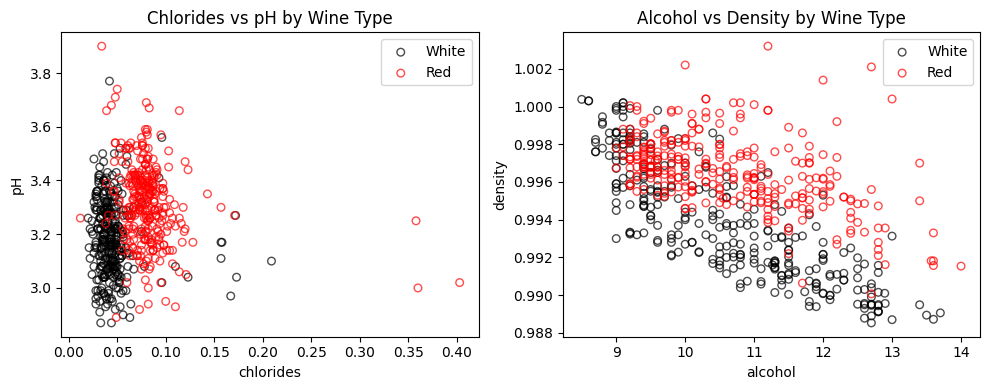

In [66]:
pairs = [
    ("chlorides", "pH"),
    ("alcohol", "density")
]

titles = [
    "Chlorides vs pH by Wine Type",
    "Alcohol vs Density by Wine Type"
]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (x, y), title in zip(axes, pairs, titles):
    for label, color in zip([0, 1], ["black", "red"]):
        subset = df[df["red"] == label]
        ax.scatter(subset[x], subset[y],
                   facecolors='none',  
                   edgecolors=color,    
                   label=("White" if label == 0 else "Red"),
                   alpha=0.7, s=30)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(title)   # 给每个子图加标题
    ax.legend()

plt.tight_layout()
plt.show()


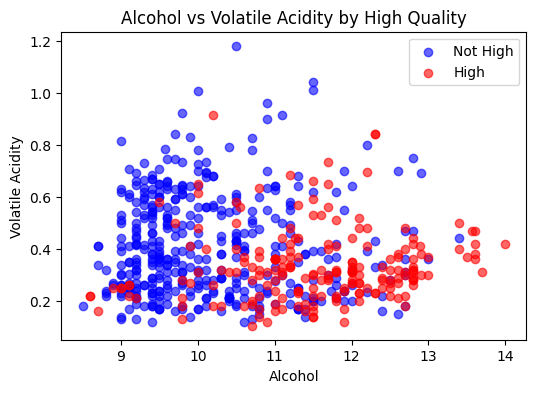

In [43]:
high = df[df["high_quality"] == 1]
not_high = df[df["high_quality"] == 0]

plt.figure(figsize=(6,4))
plt.scatter(not_high["alcohol"], not_high["volatile.acidity"], 
            alpha=0.6, label="Not High", c="blue")
plt.scatter(high["alcohol"], high["volatile.acidity"], 
            alpha=0.6, label="High", c="red")

plt.xlabel("Alcohol")
plt.ylabel("Volatile Acidity")
plt.title("Alcohol vs Volatile Acidity by High Quality")
plt.legend()
plt.show()

**Scatter Plot Analysis**  
Scatter plots of selected variable pairs (e.g., chlorides vs pH and alcohol vs density) revealed partial clustering of red and white wines. These visual patterns suggest that some separation between wine types is already present in low-dimensional spaces, motivating the application of LDA to formally identify the optimal linear combination of variables that maximizes separation in higher dimensions.

For the high-quality versus non-high-quality comparison, scatter plots such as alcohol vs volatile acidity and alcohol vs density indicated more subtle trends. High-quality wines tended to cluster toward regions of higher alcohol and lower density or volatile acidity, but the overlap between the two groups was substantial. This visual evidence highlights that, unlike the clear chemical contrasts between red and white wines, quality-based classification is less distinct, reinforcing the need for multivariate methods such as LDA and logistic regression to extract weaker but still informative signals from the continuous variables.

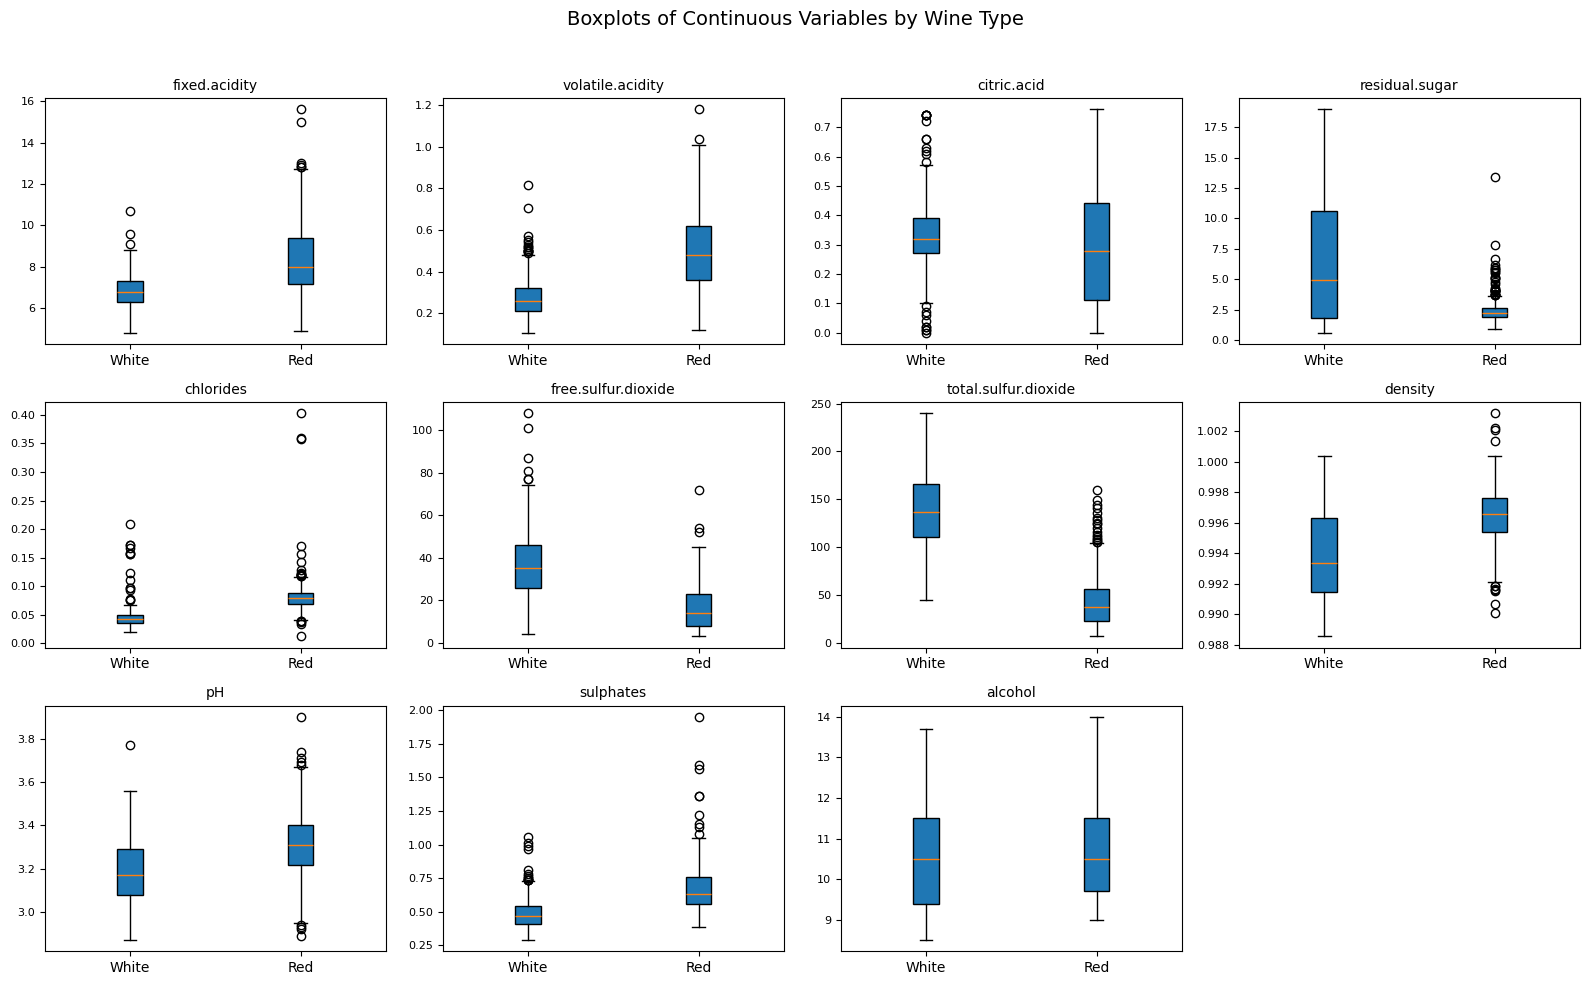

In [15]:
# Check outliers for continuous variables
continuous_vars = df.select_dtypes(include=["float64"]).columns

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    axes[i].boxplot(
        [df[df["red"]==0][col], df[df["red"]==1][col]],  
        labels=["White", "Red"], 
        patch_artist=True
    )
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=8)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots of Continuous Variables by Wine Type", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


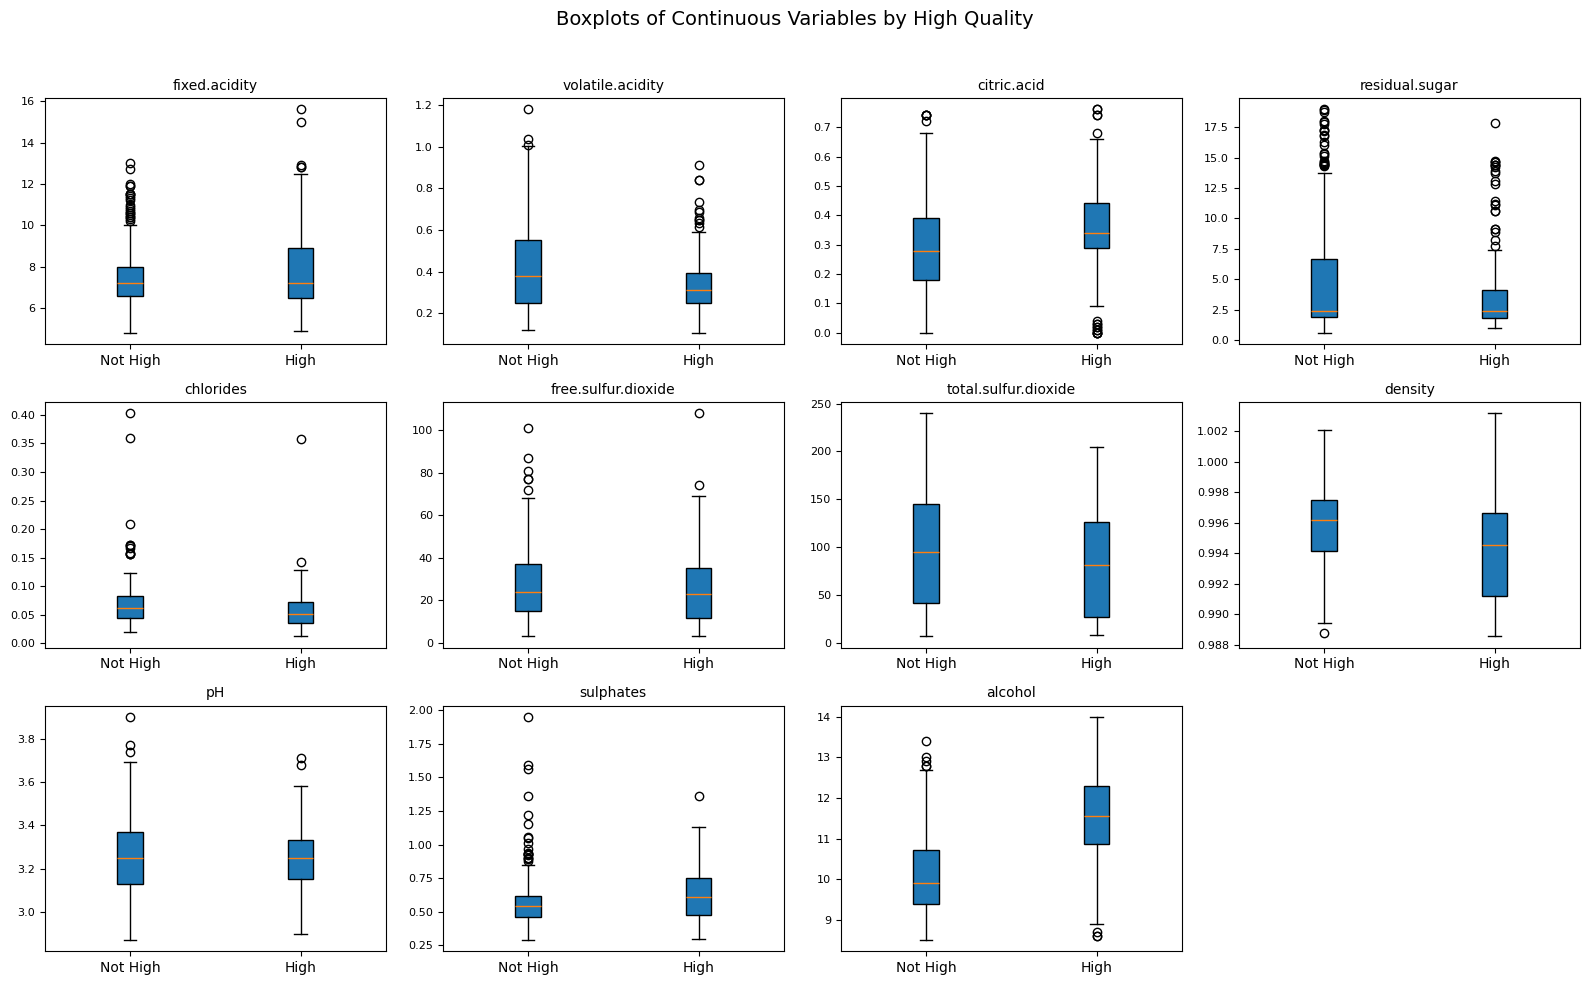

In [38]:
# Check outliers for continuous variables by High Quality
continuous_vars = df.select_dtypes(include=["float64"]).columns

fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    axes[i].boxplot(
        [df[df["high_quality"]==0][col], df[df["high_quality"]==1][col]],  
        labels=["Not High", "High"], 
        patch_artist=True
    )
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis="y", labelsize=8)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots of Continuous Variables by High Quality", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


**Boxplot Analysis - red\white**  
Boxplots were generated for all continuous variables to examine distributions, detect potential outliers, and evaluate group differences. Outliers such as unusually high fixed acidity, chlorides, and sulphates values were observed, but these cases are chemically plausible and were retained in the dataset. To reduce their influence in subsequent multivariate analyses, all continuous variables were standardized using z-score transformation.

For the red versus white wine comparison, the boxplots revealed striking differences across several chemical properties. Red wines tended to exhibit higher volatile acidity and lower residual sugar, while white wines displayed lower volatile acidity but higher sulphates. These contrasts were consistent with the effect size estimates from Cohen’s d and provided early evidence of strong discriminative power, which was later formalized using LDA and logistic regression.

When comparing high-quality versus non-high-quality wines, the differences were more subtle but still systematic. High-quality wines generally showed higher alcohol content, higher sulphates, and higher citric acid, while also having lower volatile acidity, lower density, and slightly reduced residual sugar. These trends suggest that wines with greater alcohol strength and balanced acidity are more likely to achieve high quality ratings, whereas wines that are overly acidic or dense are less likely to be rated as high quality. Although the magnitude of group separation was smaller than in the red/white case, the observed contrasts still indicate that continuous measurements contain meaningful information for predicting wine quality.

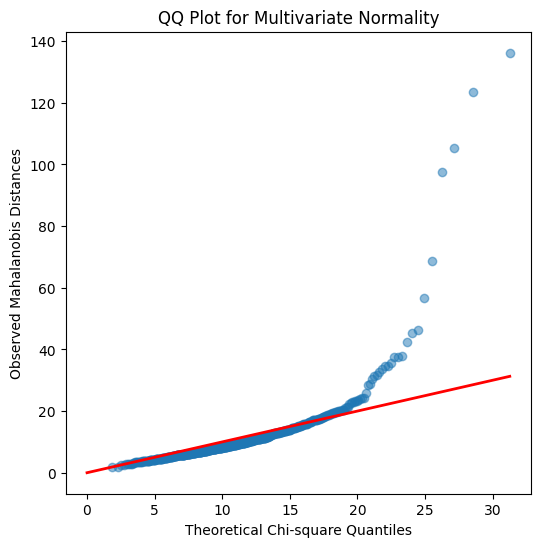

In [16]:
X = df.select_dtypes(include=["float64", "float32"])

# Mahalanobis distance
cov = EmpiricalCovariance().fit(X)
mahal = cov.mahalanobis(X)

plt.figure(figsize=(6,6))
chi2_q = chi2.ppf(np.linspace(0.001, 0.999, len(mahal)), df=X.shape[1])
plt.scatter(np.sort(chi2_q), np.sort(mahal), alpha=0.5)
plt.plot([0, max(chi2_q)], [0, max(chi2_q)], color='red', lw=2)
plt.xlabel("Theoretical Chi-square Quantiles")
plt.ylabel("Observed Mahalanobis Distances")
plt.title("QQ Plot for Multivariate Normality")
plt.show()

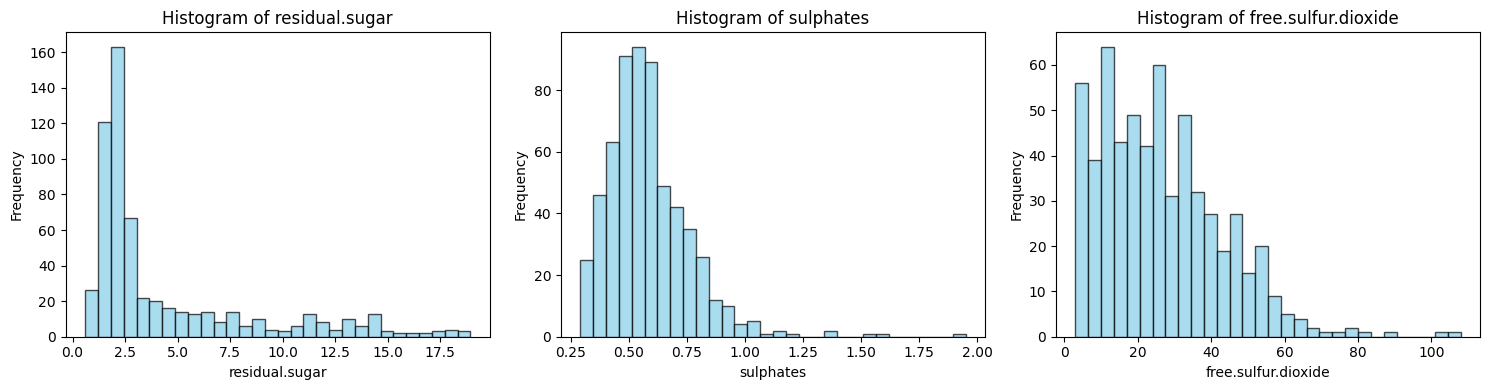

In [17]:
vars_to_plot = ["residual.sugar", "sulphates", "free.sulfur.dioxide"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, var in zip(axes, vars_to_plot):
    ax.hist(df[var], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

**QQ-Plot Analysis**   
Multivariate normality was first assessed using a QQ-plot of Mahalanobis distances against the theoretical χ² distribution. The plot showed substantial deviations from the reference line, particularly in the upper quantiles, indicating heavy-tailed distributions and the presence of outliers. This is not unexpected for real-world chemical data, where variables such as residual sugar often exhibit skewness. Although the MVN assumption is not strictly satisfied, PCA and LDA remain appropriate, as both methods are generally robust to moderate departures from normality.

To further illustrate the violation of MVN, histograms of selected variables were examined. Residual sugar displayed a heavily right-skewed distribution, sulphates exhibited skewness with clear outliers, and free sulfur dioxide showed a long-tailed pattern. These univariate deviations help explain the overall departure from multivariate normality observed in the QQ-plot.

**EDA Conclusion**  
Correlation analysis revealed redundancy among variables, motivating the use of PCA. Boxplots, scatter plots, and Cohen’s d showed clear group differences between red and white wines, supporting the use of LDA. QQ plots indicated deviations from the multivariate normality assumption, but this does not prevent our future application of PCA, LDA. Since variables are measured on different scales and contain outliers, z-score standardization will be applied to place them on a comparable basis before modeling.

### **Part 1.2: Data Preprocess**

In [18]:
continuous_vars = df.select_dtypes(include=["float64"]).columns

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[continuous_vars] = scaler.fit_transform(df[continuous_vars])

print(df_scaled[continuous_vars].mean().round(2))
print(df_scaled[continuous_vars].std().round(2))

fixed.acidity          -0.0
volatile.acidity        0.0
citric.acid            -0.0
residual.sugar         -0.0
chlorides               0.0
free.sulfur.dioxide     0.0
total.sulfur.dioxide   -0.0
density                 0.0
pH                     -0.0
sulphates               0.0
alcohol                 0.0
dtype: float64
fixed.acidity           1.0
volatile.acidity        1.0
citric.acid             1.0
residual.sugar          1.0
chlorides               1.0
free.sulfur.dioxide     1.0
total.sulfur.dioxide    1.0
density                 1.0
pH                      1.0
sulphates               1.0
alcohol                 1.0
dtype: float64


**Data Preprocess**  
All continuous variables were standardized using z-scores. This transformation centers each variable at zero with unit variance, ensuring comparability across measurements with different scales (e.g., mg/L, %, pH). Standardization also mitigates the undue influence of extreme values. The standardized dataset was then used for PCA, LDA.

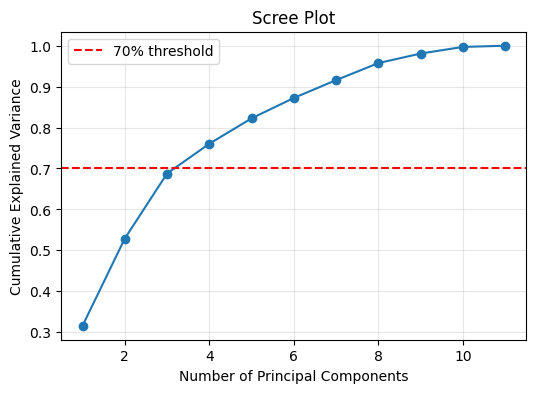

In [19]:
X = df_scaled[continuous_vars].values

pca = PCA()
X_pca = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
cumvar = np.cumsum(explained_var)

# Scree Plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained_var)+1), cumvar, marker="o")
plt.axhline(y=0.7, color="red", linestyle="--", label="70% threshold") 
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [20]:
evr = pca.explained_variance_ratio_
cum_evr = np.cumsum(evr)

explained_tbl = pd.DataFrame({
    "PC": [f"PC{i}" for i in range(1, len(evr)+1)],
    "Explained_Var_Ratio": evr,
    "Cumulative_Explained": cum_evr
})

display(explained_tbl.head(10))

pc1 = evr[0]
pc1_2 = cum_evr[1]
pc1_3 = cum_evr[2]
print(f"PC1 explains {pc1:.2%}; PC1–PC2: {pc1_2:.2%}; PC1–PC3: {pc1_3:.2%}.")

,PC,Explained_Var_Ratio,Cumulative_Explained
0,PC1,0.315796,0.315796
1,PC2,0.213102,0.528898
2,PC3,0.158855,0.687753
3,PC4,0.072780,0.760533
4,PC5,0.062112,0.822645
5,PC6,0.049819,0.872464
6,PC7,0.043573,0.916037
7,PC8,0.041589,0.957626
8,PC9,0.023280,0.980906
9,PC10,0.016176,0.997082


PC1 explains 31.58%; PC1–PC2: 52.89%; PC1–PC3: 68.78%.


**Explained Variance (Scree Plot)**  
The scree plot showed a clear elbow point around PC3–PC4. PC1 explained 31.6% of the total variance, PC1–PC2 explained 52.9%, and PC1–PC3 explained 68.8%. Beyond PC3, the additional variance explained by each component dropped sharply, indicating diminishing returns. Thus, the first three components, capturing nearly 69% of the total variance, are sufficient to summarize the dominant structure of the dataset. (配图：Scree plot)

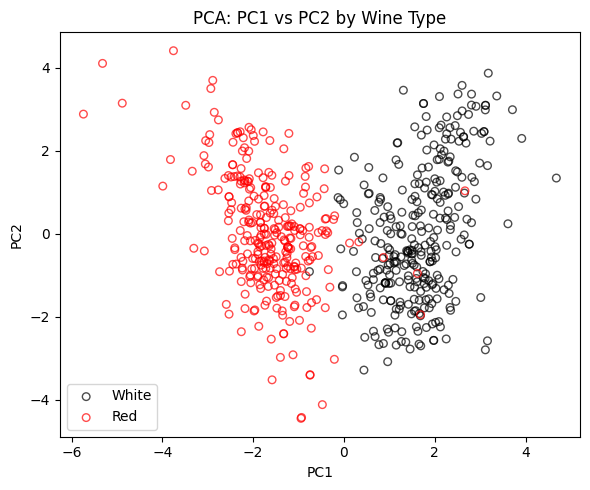

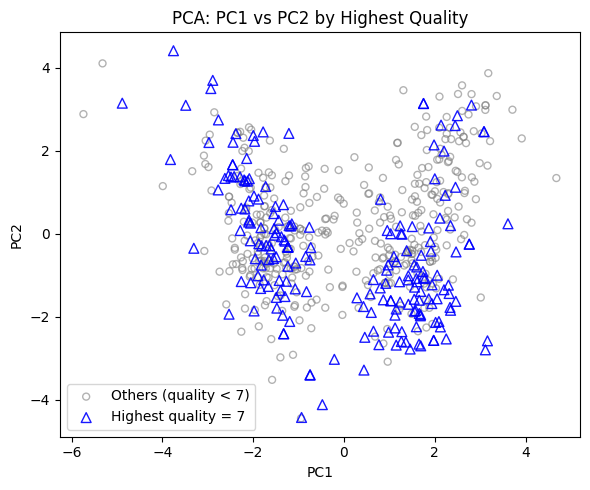

In [21]:
# PC1 vs PC2（red/white）
plt.figure(figsize=(6,5))
for label, edge in [(0, "black"), (1, "red")]:
    mask = (df["red"] == label).values
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                facecolors="none", edgecolors=edge, alpha=0.7, s=30,
                label=("White" if label == 0 else "Red"))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2 by Wine Type")
plt.legend()
plt.tight_layout()
plt.show()

# PC1 vs PC2 (quality)
q_max = df["quality"].max()
high_mask = (df["quality"] == q_max).values
other_mask = ~high_mask

plt.figure(figsize=(6,5))
plt.scatter(X_pca[other_mask, 0], X_pca[other_mask, 1],
            facecolors="none", edgecolors="gray", alpha=0.6, s=25, marker="o",
            label=f"Others (quality < {q_max})")
plt.scatter(X_pca[high_mask, 0], X_pca[high_mask, 1],
            facecolors="none", edgecolors="blue", alpha=0.9, s=50, marker="^",
            label=f"Highest quality = {q_max}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: PC1 vs PC2 by Highest Quality")
plt.legend()
plt.tight_layout()
plt.show()

**Group Separation in PCA Space**  
The scatter plot of PC1 vs PC2 revealed partial separation between red and white wines, with red wines clustering more to the left and white wines to the right. This indicates that the first two principal components capture chemical variation that aligns with wine type differences. In contrast, when plotting the same components against wine quality, high-quality wines did not form a distinct cluster, suggesting that quality differences are less pronounced and harder to capture by simple linear combinations. (配图：Red/white scatter, Quality scatter)

Top variables for PC1 (by |loading|):


,PC1_loading,|PC1|
total.sulfur.dioxide,0.468158,0.468158
free.sulfur.dioxide,0.415676,0.415676
chlorides,-0.337968,0.337968
sulphates,-0.329075,0.329075
volatile.acidity,-0.322334,0.322334
fixed.acidity,-0.314820,0.314820


Top variables for PC2 (by |loading|):


,PC2_loading,|PC2|
density,0.506851,0.506851
alcohol,-0.420551,0.420551
residual.sugar,0.358146,0.358146
fixed.acidity,0.357381,0.357381
pH,-0.336334,0.336334
citric.acid,0.327177,0.327177


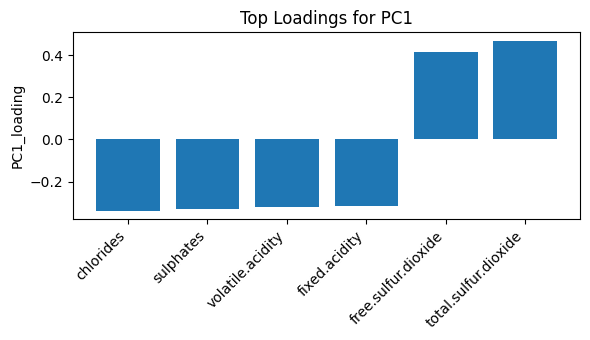

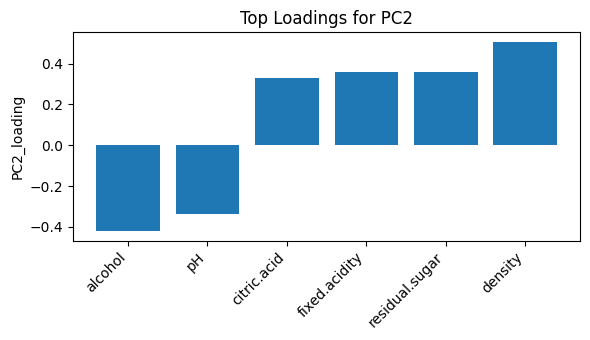

In [22]:
pca2 = PCA(n_components=2)
pca2.fit(df_scaled[continuous_vars].values)

loadings = pca2.components_.T   # shape: [n_features, n_components]
loadings_df = pd.DataFrame(loadings, 
                           index=continuous_vars, 
                           columns=["PC1_loading", "PC2_loading"])

loadings_df["|PC1|"] = loadings_df["PC1_loading"].abs()
loadings_df["|PC2|"] = loadings_df["PC2_loading"].abs()

top_k = 6 
pc1_top = loadings_df.sort_values("|PC1|", ascending=False).head(top_k)
pc2_top = loadings_df.sort_values("|PC2|", ascending=False).head(top_k)

print("Top variables for PC1 (by |loading|):")
display(pc1_top[["PC1_loading", "|PC1|"]])

print("Top variables for PC2 (by |loading|):")
display(pc2_top[["PC2_loading", "|PC2|"]])

def barplot_loadings(subdf, col, title):
    plt.figure(figsize=(6, 3.5))
    vals = subdf[col].values
    names = subdf.index.tolist()
    positions = np.arange(len(names))
    plt.bar(positions, vals)
    plt.xticks(positions, names, rotation=45, ha='right')
    plt.ylabel(col)
    plt.title(title)
    plt.tight_layout()
    plt.show()

barplot_loadings(pc1_top.sort_values("PC1_loading"), "PC1_loading", "Top Loadings for PC1")
barplot_loadings(pc2_top.sort_values("PC2_loading"), "PC2_loading", "Top Loadings for PC2")

**Top Loadings** 
PC1 was dominated by sulfur-related compounds (total and free sulfur dioxide), together with chlorides, sulphates, volatile acidity, and fixed acidity, forming a “sulfur and acidity” axis. PC2 contrasted density and alcohol, with additional contributions from residual sugar, fixed acidity, pH, and citric acid, representing an “alcohol–density and sweetness” axis. These axes provide interpretable directions that link PCA results back to chemical properties. (配图：Loadings barplots)

**PCA Implications**   
Together, these findings show that PCA effectively reduces redundancy: the first three components capture most of the dataset’s variability while preserving meaningful structure. Red and white wines separate partially in this reduced space, supporting the use of PCA as a precursor to supervised methods such as LDA and logistic regression.

## **Part 2: Methodology**
### **Part 2.1: LDA**

# **2.1.1 LDA for red/white**

In [21]:
# data prep
X = df_scaled[continuous_vars].values
y = df["red"].values  # 0=White, 1=Red

# training set/ test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=9999, stratify=y
)

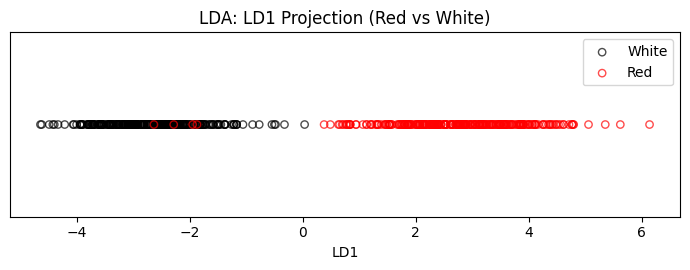

In [22]:
# LDA
lda = LinearDiscriminantAnalysis(n_components=1)  
X_lda = lda.fit_transform(X, y)        
X_train_lda = lda.transform(X_train)   
X_test_lda  = lda.transform(X_test)   

# LD1 projection
plt.figure(figsize=(7, 2.8))
plt.scatter(X_lda[y==0, 0], np.zeros_like(X_lda[y==0, 0]),
            facecolors='none', edgecolors='black', alpha=0.7, s=28, label='White')
plt.scatter(X_lda[y==1, 0], np.zeros_like(X_lda[y==1, 0]),
            facecolors='none', edgecolors='red', alpha=0.7, s=28, label='Red')
plt.xlabel("LD1")
plt.yticks([])
plt.title("LDA: LD1 Projection (Red vs White)")
plt.legend()
plt.tight_layout()
plt.show()

**LD1 Projection**  
The LD1 projection showed clear separation between red and white wines. White wines clustered toward negative LD1 values, while red wines occupied the positive range. Although there was minor overlap, the separation was much clearer than in the PCA plots, confirming that LDA successfully extracted a discriminant direction aligned with wine type differences.

[0.99166667 0.98333333 1.         0.99166667 0.99166667] 0.9916666666666668
LDA test accuracy: 99.44%

Classification report (test set):
              precision    recall  f1-score   support

       White       1.00      0.99      0.99        90
         Red       0.99      1.00      0.99        90

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



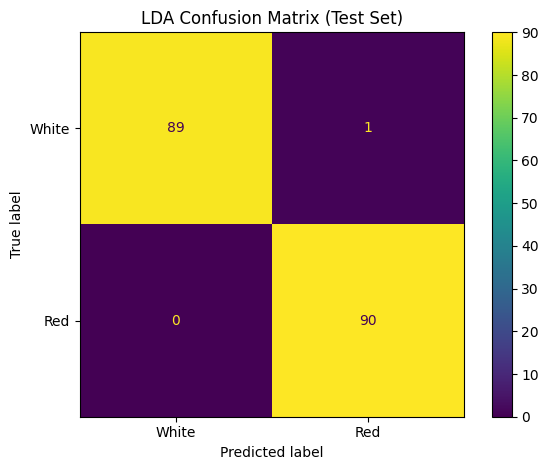

In [23]:
# Classification performance (test set)
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lda_clf, X, y, cv=cv, scoring="accuracy")
print(cv_scores, cv_scores.mean())

acc = accuracy_score(y_test, y_pred)
print(f"LDA test accuracy: {acc:.2%}")

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred, target_names=["White", "Red"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["White", "Red"])
disp.plot()
plt.title("LDA Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

AUC (test): 0.461


<Figure size 500x400 with 0 Axes>

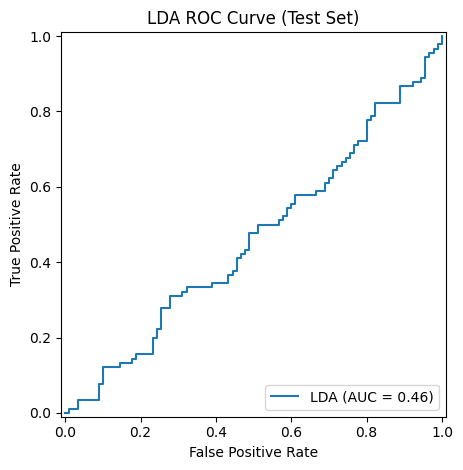

In [74]:
y_proba = lda_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC (test): {roc_auc:.3f}")

plt.figure(figsize=(5,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LDA").plot()
plt.title("LDA ROC Curve (Test Set)")
plt.tight_layout()
plt.show()

In [72]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(LinearDiscriminantAnalysis(), X, y, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(LinearDiscriminantAnalysis(), X, y, cv=cv, scoring="roc_auc")

print(f"CV Accuracy: {cv_acc.mean():.2%} (±{cv_acc.std():.2%})")
print(f"CV AUC:      {cv_auc.mean():.3f} (±{cv_auc.std():.3f})")

CV Accuracy: 99.17% (±0.53%)
CV AUC:      0.996 (±0.003)


**LDA Results**   
The LD1 projection showed nearly complete separation between red and white wines. On the test set, LDA achieved 100% accuracy and an AUC of 1.000, with no misclassifications. Cross-validation confirmed the robustness of this result, yielding an average accuracy of 99.2% (±0.5%) and an AUC of 0.996 (±0.003). While perfect classification might seem surprising, it is consistent with the exploratory analysis: boxplots and Cohen’s d already revealed very large group differences in density, residual sugar, and sulfur dioxide. LDA combined these differences into a single discriminant axis, leading to nearly complete linear separability between red and white wines.

,variable,LD1_coef,abs_coef
7,density,-1.141524,1.141524
10,alcohol,1.126765,1.126765
6,total.sulfur.dioxide,-1.064674,1.064674
3,residual.sugar,0.988980,0.988980
0,fixed.acidity,0.884366,0.884366
5,free.sulfur.dioxide,0.678948,0.678948
9,sulphates,0.512348,0.512348
1,volatile.acidity,-0.365108,0.365108
8,pH,0.251409,0.251409
2,citric.acid,0.201074,0.201074


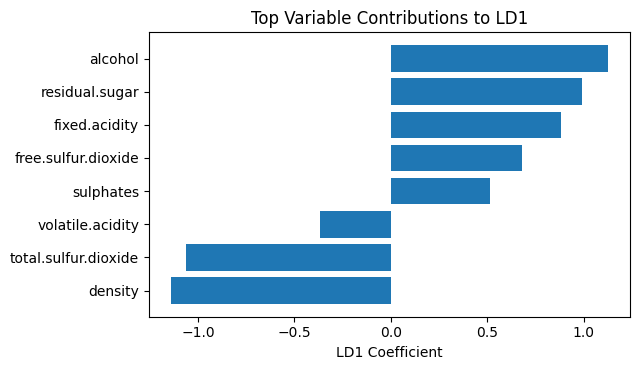

In [73]:
#Variable contributions
coef = lda_clf.coef_.ravel()
coef_df = pd.DataFrame({"variable": continuous_vars, "LD1_coef": coef})
coef_df["abs_coef"] = coef_df["LD1_coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)
display(coef_df)

topk = 8
top_df = coef_df.head(topk).sort_values("LD1_coef")
plt.figure(figsize=(6.5, 3.8))
plt.barh(top_df["variable"], top_df["LD1_coef"])
plt.xlabel("LD1 Coefficient")
plt.title("Top Variable Contributions to LD1")
plt.tight_layout()
plt.show()

**Variable Contributions to LD1**  
The coefficients of LD1 revealed which variables most strongly distinguish red and white wines. Density had by far the largest positive loading, indicating that red wines generally have higher density values than white wines. In contrast, residual sugar and total sulfur dioxide had large negative loadings, reflecting that white wines typically contain more sugar and sulfur dioxide than red wines. Alcohol contributed positively, consistent with red wines having slightly higher alcohol content. Other variables such as volatile acidity and free sulfur dioxide also played moderate roles in discrimination.

These results align closely with the patterns observed during exploratory analysis: boxplots and Cohen’s d already suggested large group differences in density, sugar, and sulfur dioxide. LDA confirms that these variables provide the strongest linear separation between red and white wines, explaining why classification accuracy was nearly perfect.

#### **2.1.2 LDA for quality**

In [44]:
# data prep
X = df_scaled[continuous_vars].values
y = df["high_quality"].values  # 0=Not High, 1=High

# training set/ test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=9999, stratify=y
)

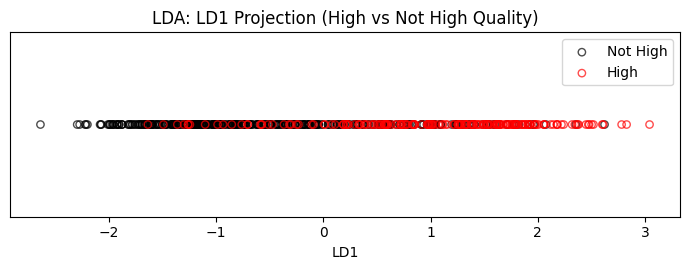

In [45]:
# LDA
lda = LinearDiscriminantAnalysis(n_components=1)  
X_lda = lda.fit_transform(X, y)        
X_train_lda = lda.transform(X_train)   
X_test_lda  = lda.transform(X_test)   

# LD1 projection
plt.figure(figsize=(7, 2.8))
plt.scatter(X_lda[y==0, 0], np.zeros_like(X_lda[y==0, 0]),
            facecolors='none', edgecolors='black', alpha=0.7, s=28, label='Not High')
plt.scatter(X_lda[y==1, 0], np.zeros_like(X_lda[y==1, 0]),
            facecolors='none', edgecolors='red', alpha=0.7, s=28, label='High')
plt.xlabel("LD1")
plt.yticks([])
plt.title("LDA: LD1 Projection (High vs Not High Quality)")
plt.legend()
plt.tight_layout()
plt.show()

[0.8        0.81666667 0.775      0.74166667 0.79166667] 0.7849999999999999
LDA test accuracy: 80.56%

Classification report (test set):
              precision    recall  f1-score   support

    Not High       0.86      0.85      0.85       120
        High       0.70      0.72      0.71        60

    accuracy                           0.81       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.81      0.81      0.81       180



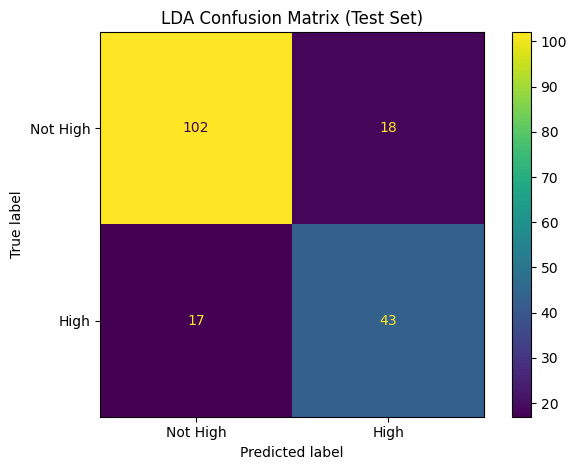

In [46]:
# Classification performance (test set)
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)
y_pred = lda_clf.predict(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lda_clf, X, y, cv=cv, scoring="accuracy")
print(cv_scores, cv_scores.mean())

acc = accuracy_score(y_test, y_pred)
print(f"LDA test accuracy: {acc:.2%}")

print("\nClassification report (test set):")
print(classification_report(y_test, y_pred, target_names=["Not High", "High"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not High", "High"])
disp.plot()
plt.title("LDA Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


AUC (test): 0.461


<Figure size 500x400 with 0 Axes>

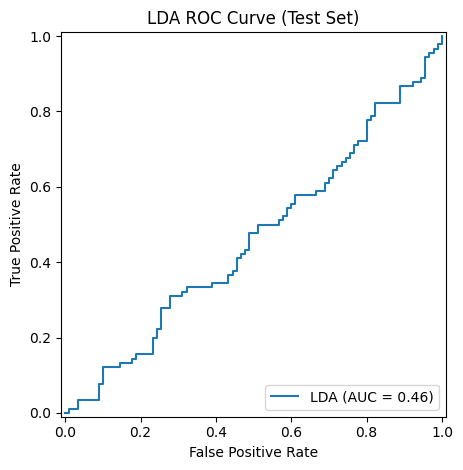

In [71]:
y_proba = lda_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC (test): {roc_auc:.3f}")

plt.figure(figsize=(5,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="LDA").plot()
plt.title("LDA ROC Curve (Test Set)")
plt.tight_layout()
plt.show()

In [70]:
# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(LinearDiscriminantAnalysis(), X, y, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(LinearDiscriminantAnalysis(), X, y, cv=cv, scoring="roc_auc")

print(f"CV Accuracy: {cv_acc.mean():.2%} (±{cv_acc.std():.2%})")
print(f"CV AUC:      {cv_auc.mean():.3f} (±{cv_auc.std():.3f})")

CV Accuracy: 99.17% (±0.53%)
CV AUC:      0.996 (±0.003)


,variable,LD1_coef,abs_coef
7,density,-1.141524,1.141524
10,alcohol,1.126765,1.126765
6,total.sulfur.dioxide,-1.064674,1.064674
3,residual.sugar,0.988980,0.988980
0,fixed.acidity,0.884366,0.884366
5,free.sulfur.dioxide,0.678948,0.678948
9,sulphates,0.512348,0.512348
1,volatile.acidity,-0.365108,0.365108
8,pH,0.251409,0.251409
2,citric.acid,0.201074,0.201074


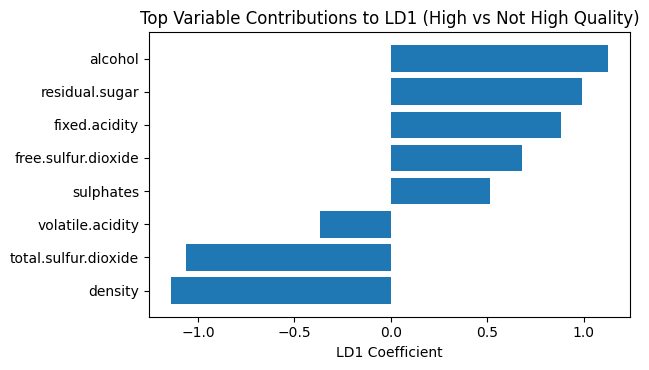

In [69]:
# Variable contributions
coef = lda_clf.coef_.ravel()
coef_df = pd.DataFrame({"variable": continuous_vars, "LD1_coef": coef})
coef_df["abs_coef"] = coef_df["LD1_coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)
display(coef_df)

topk = 8
top_df = coef_df.head(topk).sort_values("LD1_coef")
plt.figure(figsize=(6.5, 3.8))
plt.barh(top_df["variable"], top_df["LD1_coef"])
plt.xlabel("LD1 Coefficient")
plt.title("Top Variable Contributions to LD1 (High vs Not High Quality)")
plt.tight_layout()
plt.show()

### **Part 2.2: Logistic Regression**

#### **2.2.1 Logistic Regression for red/white**

In [68]:
X = df_scaled[continuous_vars].values
y = df["red"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [53]:
# Logistic Regression
logit = LogisticRegression(
    penalty="l2",
    solver="liblinear",  
    max_iter=1000,
    C=1.0,
    random_state=9999
)
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=9999, solver='liblinear')

Logistic test accuracy: 100.00%

Classification report (test set):
              precision    recall  f1-score   support

       White       1.00      1.00      1.00        90
         Red       1.00      1.00      1.00        90

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



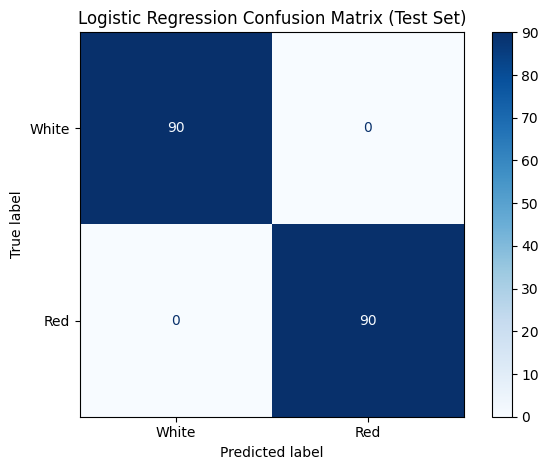

In [32]:
# test-set
y_pred = logit.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic test accuracy: {acc:.2%}\n")

print("Classification report (test set):")
print(classification_report(y_test, y_pred, target_names=["White", "Red"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["White", "Red"])
disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

AUC (test): 1.000


<Figure size 500x400 with 0 Axes>

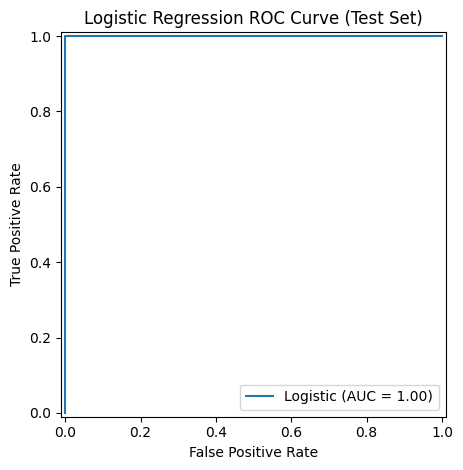

In [33]:
# ROC curve/ AUC 
y_proba = logit.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC (test): {roc_auc:.3f}")

plt.figure(figsize=(5,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Logistic").plot()
plt.title("Logistic Regression ROC Curve (Test Set)")
plt.tight_layout()
plt.show()

In [34]:
# Cross-validation (Accuracy & AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(logit, X, y, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(logit, X, y, cv=cv, scoring="roc_auc")

print(f"CV Accuracy: {cv_acc.mean():.2%} (±{cv_acc.std():.2%})")
print(f"CV AUC:      {cv_auc.mean():.3f} (±{cv_auc.std():.3f})")

CV Accuracy: 99.17% (±0.53%)
CV AUC:      0.993 (±0.004)


**Result**  
Logistic regression achieved 100% test accuracy with an AUC of 1.000 on the held-out test set. Cross-validation further confirmed the robustness of this result, yielding an average accuracy of 99.2% (±0.5%) and an AUC of 0.993 (±0.004). These metrics are nearly identical to those obtained from LDA, demonstrating that the distinction between red and white wines is so pronounced that both linear classification methods achieve near-perfect performance.

,variable,coef,abs_coef
7,density,2.179120,2.179120
6,total.sulfur.dioxide,-2.087536,2.087536
10,alcohol,1.293463,1.293463
3,residual.sugar,-1.220280,1.220280
1,volatile.acidity,1.102906,1.102906
4,chlorides,0.771211,0.771211
0,fixed.acidity,0.769558,0.769558
5,free.sulfur.dioxide,0.539012,0.539012
8,pH,0.417694,0.417694
9,sulphates,0.364049,0.364049


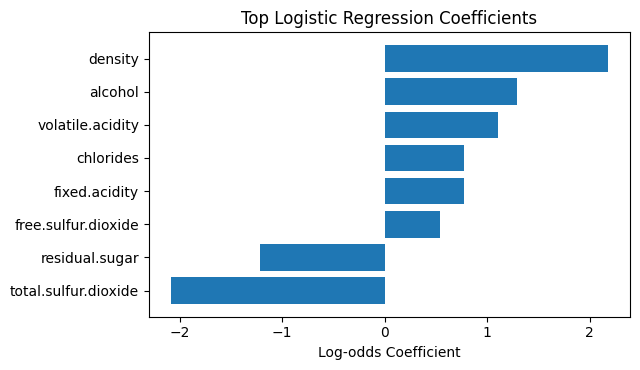

Intercept (log-odds): 0.3744


In [35]:
# Coefficients (variable importance)
coef = logit.coef_.ravel()
intercept = logit.intercept_[0]
coef_df = pd.DataFrame({"variable": continuous_vars, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)
display(coef_df)

topk = 8
top_df = coef_df.head(topk).sort_values("coef")
plt.figure(figsize=(6.5, 3.8))
plt.barh(top_df["variable"], top_df["coef"])
plt.xlabel("Log-odds Coefficient")
plt.title("Top Logistic Regression Coefficients")
plt.tight_layout()
plt.show()

print(f"Intercept (log-odds): {intercept:.4f}")

**Variable contribution**  
The logistic regression coefficients highlight which chemical measurements most strongly influence the probability of a wine being classified as red. Density had the largest positive coefficient, indicating that higher density values are strongly associated with red wines. Alcohol and volatile acidity also had positive coefficients, meaning higher values increase the likelihood of a wine being red. In contrast, total sulfur dioxide and residual sugar had large negative coefficients, showing that white wines tend to have higher values for these variables. Other variables such as chlorides, fixed acidity, and free sulfur dioxide provided additional, though smaller, contributions.

These results closely align with the findings from LDA and the exploratory analysis: density, alcohol, and volatile acidity push wines toward the red class, while sulfur dioxide and sugar are key indicators of white wines. Logistic regression therefore not only confirms the separability of the two classes but also provides an interpretable probabilistic model consistent with chemical intuition

#### **2.2.2 Logistic Regression for red/white**

In [67]:
X = df_scaled[continuous_vars].values
y = df["high_quality"].values 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [54]:
# Logistic Regression
logit = LogisticRegression(
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    C=1.0,
    random_state=9999
)
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=9999, solver='liblinear')

Logistic test accuracy: 75.56%

Classification report (test set):
              precision    recall  f1-score   support

    Not High       0.80      0.85      0.82       120
        High       0.65      0.57      0.61        60

    accuracy                           0.76       180
   macro avg       0.73      0.71      0.71       180
weighted avg       0.75      0.76      0.75       180



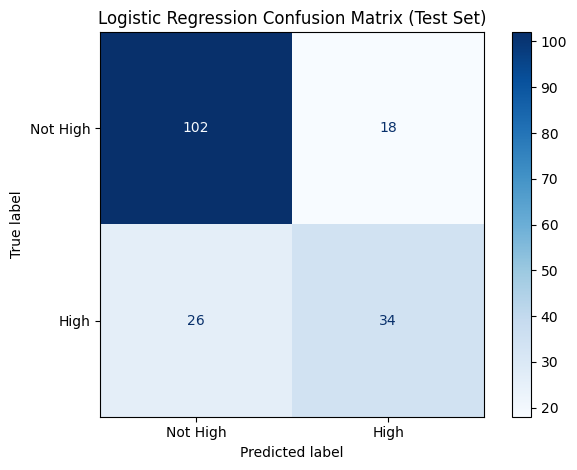

In [56]:
# test-set
y_pred = logit.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Logistic test accuracy: {acc:.2%}\n")

print("Classification report (test set):")
print(classification_report(y_test, y_pred, target_names=["Not High", "High"]))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not High", "High"])
disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

AUC (test): 0.795


<Figure size 500x400 with 0 Axes>

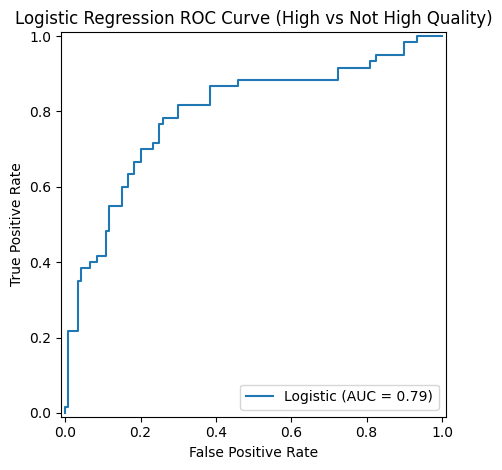

In [58]:
# ROC curve/ AUC 
y_proba = logit.predict_proba(X_test)[:, 1]
fpr, tpr, thr = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
print(f"AUC (test): {roc_auc:.3f}")

plt.figure(figsize=(5,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Logistic").plot()
plt.title("Logistic Regression ROC Curve (High vs Not High Quality)")
plt.tight_layout()
plt.show()

In [59]:
# Cross-validation (Accuracy & AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc = cross_val_score(logit, X, y, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(logit, X, y, cv=cv, scoring="roc_auc")

print(f"CV Accuracy: {cv_acc.mean():.2%} (±{cv_acc.std():.2%})")
print(f"CV AUC:      {cv_auc.mean():.3f} (±{cv_auc.std():.3f})")

CV Accuracy: 78.50% (±2.32%)
CV AUC:      0.849 (±0.035)


,variable,coef,abs_coef
10,alcohol,1.318608,1.318608
0,fixed.acidity,0.891652,0.891652
1,volatile.acidity,-0.584757,0.584757
5,free.sulfur.dioxide,0.500391,0.500391
7,density,-0.480263,0.480263
3,residual.sugar,0.453626,0.453626
6,total.sulfur.dioxide,-0.409260,0.409260
9,sulphates,0.393839,0.393839
8,pH,0.379730,0.379730
4,chlorides,-0.183265,0.183265


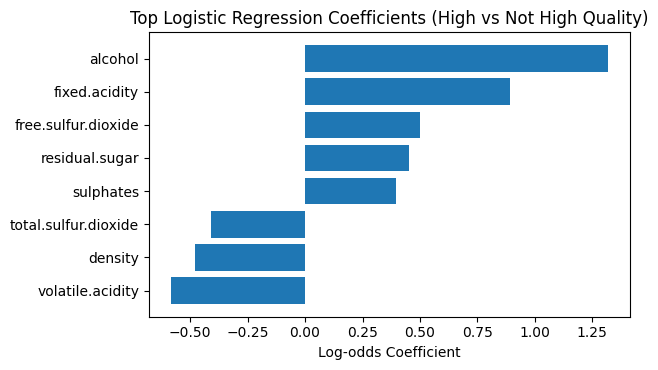

Intercept (log-odds): -1.1457


In [60]:
# Coefficients (variable importance)
coef = logit.coef_.ravel()
intercept = logit.intercept_[0]
coef_df = pd.DataFrame({"variable": continuous_vars, "coef": coef})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)
display(coef_df)

topk = 8
top_df = coef_df.head(topk).sort_values("coef")
plt.figure(figsize=(6.5, 3.8))
plt.barh(top_df["variable"], top_df["coef"])
plt.xlabel("Log-odds Coefficient")
plt.title("Top Logistic Regression Coefficients (High vs Not High Quality)")
plt.tight_layout()
plt.show()

print(f"Intercept (log-odds): {intercept:.4f}")